In [4]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
from venn import venn
import itertools

In [2]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# file_name = 'longest.mk.vM_tG.tsv'
# file_name = 'longest.mk.vM_tG_pN.tsv'
# file_name = 'longest.mk.strict.vM_tG_pN.tsv'
# file_name = 'MK_test_vidCha_group/gene.longest.mk.tsv'
# file_name = 'MK_test_indInd_group/gene.longest.mk.tsv'

# db = 'vidMac'
# db = 'vidCha'
db = 'indInd'

file_name = 'MK_test_{}_ncbi/gene.longest.mk.tsv'.format(db)

file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df.dropna()

df.head()

,gene,transcript,pN,pS,dN,dS,mk.raw.p.value,mk.odds.ni,dos
156,LATS2,XM_054390934.1,1.0,1.0,13.000000,62.000000,0.332536,4.769231,-0.326667
201,FRY,XM_054388340.1,1.0,12.0,9.000000,78.000000,1.000000,0.722222,0.026525
202,ZAR1L,XM_054389283.1,2.0,2.0,33.333333,26.666667,1.000000,0.787879,0.055556
203,BRCA2,XM_054382717.1,30.0,20.0,236.500000,94.500000,0.100901,0.597458,0.114502
205,LOC128969273,XM_054384067.1,0.0,2.0,44.500000,24.500000,0.134576,0.000000,0.644928


In [3]:
# df['gene'] = [t.split('_')[0] for t in df['transcript']]
min_odds = df[df['mk.odds.ni'] != 0]['mk.odds.ni'].min()
max_odds = df[df['mk.odds.ni'] != float('inf')]['mk.odds.ni'].max()
df['corr.ni'] = [min_odds/4 if i==0 else max_odds*4 if i==float('inf') else i for i in df['mk.odds.ni']]
# df['adj.pval'] = smt.multipletests(list(df['mk.raw.p.value']), method='fdr_bh', is_sorted=False)[1]
df['log.pval'] = -np.log10(df['mk.raw.p.value'])
df['log.ni'] = -np.log10(df['corr.ni'])

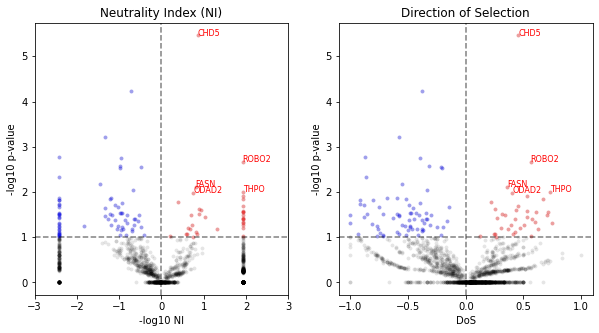

In [5]:
# selected_genes = ['GYS2', 'PTCHD1', 'LEMD2', 'NXPH3', 'LRRTM3', 'LEMD2', 'AGRN', 'CACNB1',
#                   'CNTNAP1', 'NLGN3', 'PCM1', 'SPTBN4', 'TNC', 'TUBGCP2', 'UNC5B', 'VPS13B']
# selected_genes = ['GRIN2C', 'NTRK2', 'PCM1', 'PKD1L2', 'TUBGCP2', 'TAS1R1', 'SI', 'TBC1D9', 'AAAS']
# selected_genes = ['NTRK2']
selected_genes = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes[0], axes[1]

# pval_cutoff = -np.log10(0.05)
pval_cutoff = -np.log10(0.1)

df_Dpos = df[(df['dos'] > 0) & (df['log.pval'] > pval_cutoff)]
df_Ddel = df[(df['dos'] < 0) & (df['log.pval'] > pval_cutoff)]
df_NIpos = df[(df['log.ni'] > 0) & (df['log.pval'] > pval_cutoff)]
df_NIdel = df[(df['log.ni'] < 0) & (df['log.pval'] > pval_cutoff)]

## Neutrality Index (OR)
sns.scatterplot(ax=ax1, data=df, x='log.ni', y='log.pval', alpha=0.1, linewidth=0, s=15, color='k')
sns.scatterplot(ax=ax1, data=df_NIpos, x='log.ni', y='log.pval', alpha=0.3, linewidth=0, s=15, color='red')
sns.scatterplot(ax=ax1, data=df_NIdel, x='log.ni', y='log.pval', alpha=0.3, linewidth=0, s=15, color='blue')
ax1.set_title('Neutrality Index (NI)')
ax1.set(xlabel='-log10 NI', ylabel='-log10 p-value')
ax1.set_xlim(-3,3)
ax1.axhline(pval_cutoff, color='k', alpha=0.5, ls='--')
ax1.axvline(0, color='k', alpha=0.5, ls='--')

## Directionality of Selection
sns.scatterplot(ax=ax2, data=df, x='dos', y='log.pval', alpha=0.1, linewidth=0, s=15, color='k')
sns.scatterplot(ax=ax2, data=df_Dpos, x='dos', y='log.pval', alpha=0.3, linewidth=0, s=15, color='red')
sns.scatterplot(ax=ax2, data=df_Ddel, x='dos', y='log.pval', alpha=0.3, linewidth=0, s=15, color='blue')
ax2.set_title('Direction of Selection')
ax2.set(xlabel='DoS', ylabel='-log10 p-value')
ax2.axhline(pval_cutoff, color='k', alpha=0.5, ls='--')
ax2.axvline(0, color='k', alpha=0.5, ls='--')


labels = []
for x, y, g in zip(df_NIpos['log.ni'], df_NIpos['log.pval'], df_NIpos['gene']):
    if (g in selected_genes) or ((y > 1.95) and (not g.startswith('LOC')) and (not g.startswith('reg_'))):
        labels.append(ax1.text(x=x, y=y, s=g, color='red', size=8))
        
# labels = []
# for x, y, g in zip(df_NIdel['log.ni'], df_NIdel['log.pval'], df_NIdel['gene']):
#     if (g in selected_genes) or ((y > 2.8) and (not g.startswith('LOC')) and (not g.startswith('reg_'))):
#         labels.append(ax1.text(x=x, y=y, s=g, color='blue', size=8))
        
labels = []
for x, y, g in zip(df_Dpos['dos'], df_Dpos['log.pval'], df_Dpos['gene']):
    if (g in selected_genes) or ((y > 1.95) and (not g.startswith('reg_')) and (not g.startswith('LOC'))):
        labels.append(ax2.text(x=x, y=y, s=g, color='red', size=8))

# labels = []
# for x, y, g in zip(df_Ddel['dos'], df_Ddel['log.pval'], df_Ddel['gene']):
#     if (g in selected_genes) or ((y > 2.8) and (not g.startswith('reg_')) and (not g.startswith('LOC'))):
#         labels.append(ax2.text(x=x, y=y, s=g, color='blue', size=8))
        
# pdf_name = 'ni.dos.pval_volcanos.mk_test.vM_tG.pdf'
# pdf_name = 'ni.dos.pval_volcanos.mk_test.vM_tG_pN.pdf'
# pdf_name = 'ni.dos.pval_volcanos.mk_test.strict.vM_tG_pN.pdf'
# pdf_name = 'ni.dos.pval_volcanos.mk_test.vC_tG_pN.pdf'
# pdf_name = 'ni.dos.pval_volcanos.mk_test.iI_pP_mA.no_label.pdf'
pdf_name = 'MK_test_{}_ncbi/ni.dos.pval_volcanos.mk_test.{}.ncbi.pdf'.format(db, db)

# fig.savefig(pdf_name, bbox_inches='tight')

In [73]:
df_Dpos.sort_values(by='log.pval', ascending=False)['gene']

14616           DNAH1
17640           TIGD4
14145        CEP112_0
454           CTTNBP2
13680            ODF2
499            CCDC77
3850             URI1
14138           RASA2
1332     LOC100228361
4038     LOC100225050
1312           DNAH17
3391            ALG14
8253     LOC115496113
11336    LOC100223270
8284            BRIP1
17786           CENPN
8190             CRB1
Name: gene, dtype: object

In [76]:
df_Ddel.sort_values(by='log.pval', ascending=False)
df[df['gene'] == 'PIEZO1']

,gene,transcript,pN,pS,dN,dS,mk.raw.p.value,mk.odds.ni,dos,corr.ni,log.pval,log.ni


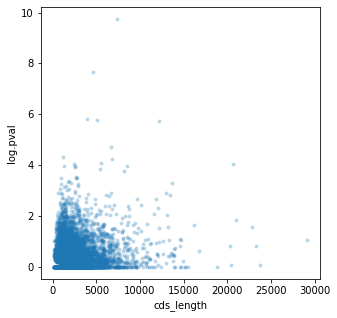

In [13]:
## Add CDS length
file_name = 'longest.transcript-counts.vM_tG_pN.tsv'
file_data = glob(dir_path + file_name)[0]
cds_df = pd.read_csv(file_data, sep='\t')
df_merged = pd.merge(df, cds_df, on='transcript')

## Correlation between significance and CDS length? NOPE
fig, axes = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=df_merged[df_merged['cds_length']<30000], y='log.pval', x='cds_length',
                alpha=0.3, linewidth=0, s=15)

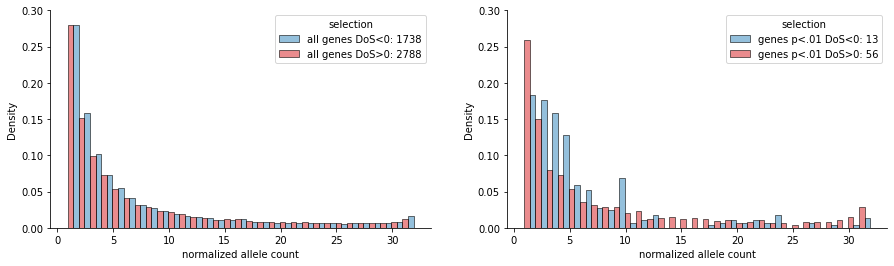

In [129]:
## Allele frequency spectra
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites/MK_test/'
file_name = 'AF.by_category.tsv'
file_data = glob(dir_path + file_name)[0]
af_df = pd.read_csv(file_data, sep='\t')
af_df['count'] = af_df['AF'] * 32

af_df_strong = af_df[af_df['selection'].isin(['strong_positive', 'strong_negative'])]
af_df_rand = af_df[af_df['selection'].isin(['rand_positive', 'rand_negative', 'all_positive', 'all_negative'])]

## plot
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
ax1, ax2 = axes[0], axes[1]
sns.set_palette(['#d7191c', '#2b83ba'])


sns.histplot(ax=ax1, data=af_df_rand, x='count', hue='selection', binwidth=1, 
             stat='density', common_norm=False, multiple="dodge", alpha=0.5)
sns.histplot(ax=ax2, data=af_df_strong, x='count', hue='selection', binwidth=1, 
             stat='density', common_norm=False, multiple="dodge", alpha=0.5)

ax1.set(xlabel='normalized allele count')
ax2.set(xlabel='normalized allele count')
ax1.legend(title='selection', loc='upper right', labels=['all genes DoS<0: 1738', 'all genes DoS>0: 2788'])
ax2.legend(title='selection', loc='upper right', labels=['genes p<.01 DoS<0: 13', 'genes p<.01 DoS>0: 56'])
ax1.set(ylim=(0, 0.3))
ax2.set(ylim=(0, 0.3))
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

pdf_name = 'spectra_AF_all_and_strong.pdf'

# fig.savefig(pdf_name, bbox_inches='tight')

all nonsyn variants DoS>0 vs DoS<0, p-value: 1.0
strong nonsyn variants DoS>0 vs DoS<0, p-value: 1.9303894371880403e-07


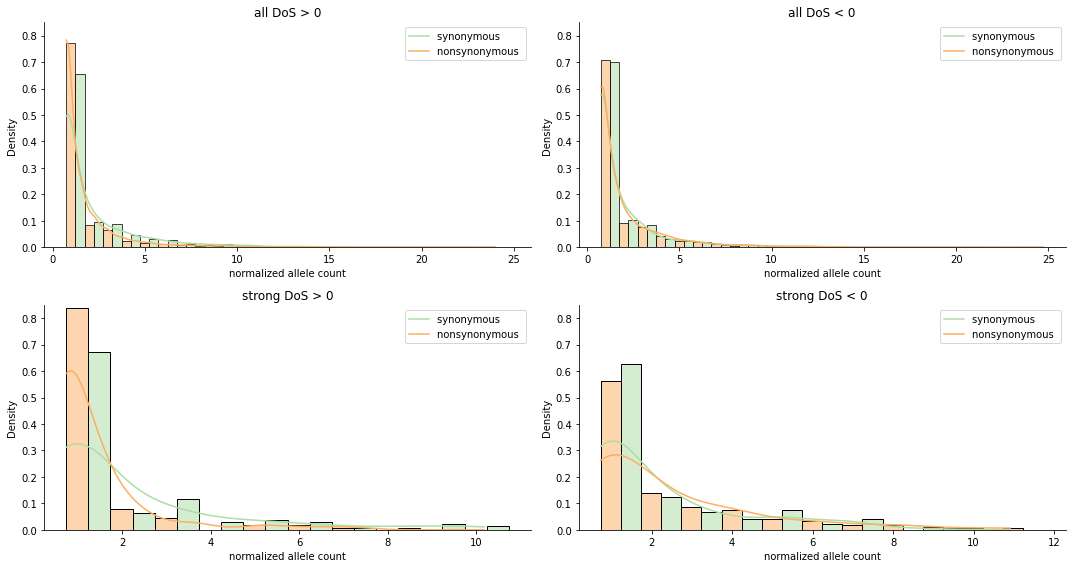

In [81]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# file_name = 'strict_filt.AF.by_category.snpEff.tsv'
# file_name = 'MK_test_vidMac_group/snpEff/AF.by_category.snpEff.tsv'
file_name = 'MK_test_vidCha_group/snpEff/AF.by_category.snpEff.tsv'

file_data = glob(dir_path + file_name)[0]
af_df = pd.read_csv(file_data, sep='\t')
af_df['count'] = af_df['AF'] * 32

data_all_pos = af_df[af_df['selection_conservative'] == 'all_positive']
data_all_neg = af_df[af_df['selection_conservative'] == 'all_negative']
data_strong_pos = af_df[af_df['selection_conservative'] == 'strong_positive']
data_strong_neg = af_df[af_df['selection_conservative'] == 'strong_negative']
# af_df_strong = af_df[af_df['selection'].isin(['strong_positive', 'strong_negative'])]
af_df_rand = af_df[af_df['selection'].isin(['rand_positive', 'rand_negative', 'all_positive', 'all_negative'])]

## plot
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
sns.set_palette(['#fdae61', '#abdda4'])

## all genes
sns.histplot(ax=ax1, data=data_all_pos, x='count', 
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

sns.histplot(ax=ax2, data=data_all_neg, x='count',
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

## strong genes
sns.histplot(ax=ax3, data=data_strong_pos, x='count', 
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

sns.histplot(ax=ax4, data=data_strong_neg, x='count',
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

ax1.set_title('all DoS > 0')
ax2.set_title('all DoS < 0')
ax3.set_title('strong DoS > 0')
ax4.set_title('strong DoS < 0')

for axi in [ax1, ax2, ax3, ax4]:
    axi.legend(title='', loc='upper right', labels=['synonymous ', 'nonsynonymous '])
    axi.set(xlabel='normalized allele count')
    axi.set(ylim=(0, 0.85))

fig.tight_layout()  
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

pdf_name = 'spectra_AF_sym_nonsym.all_and_strong.pos_and_neg.pdf'

# fig.savefig(pdf_name, bbox_inches='tight')


### Compare distributions
print('all nonsyn variants DoS>0 vs DoS<0, p-value: {}'.format(stats.ks_2samp(data_all_pos[data_all_pos['impact'] == 'missense_variant']['AF'], 
               data_all_neg[data_all_neg['impact'] == 'missense_variant']['AF'], 
               alternative='two-sided')[1]))
print('strong nonsyn variants DoS>0 vs DoS<0, p-value: {}'.format(stats.ks_2samp(data_strong_pos[data_strong_pos['impact'] == 'missense_variant']['AF'], 
               data_strong_neg[data_strong_neg['impact'] == 'missense_variant']['AF'], 
               alternative='two-sided')[1]))

In [32]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# dbs = ['vidMac', 'vidCha']
dbs = ['indInd', 'indInd_ground', 'indInd_tree']
# file_names = ['MK_test_vidMac_group/gene.longest.mk.tsv', 'MK_test_vidCha_group/gene.longest.mk.tsv']
dir_names = ['MK_test_indInd_group', 'MK_test_indInd_ground', 'MK_test_indInd_tree']

D = {}
for i in range(len(dbs)):
    db = dbs[i]
    file_name = '{}/gene.longest.mk.tsv'.format(dir_names[i])
    file_data = glob(dir_path + file_name)[0]
    d = pd.read_csv(file_data, sep='\t')
    d = d.dropna()
    D[db] = d
    i += 1

In [33]:
def get_genes_dos_pval(d, dos, pval):
    ## returns list of genes from dataframe according to requested thresholds
    
    if dos == 'pos':
        return set(d[(d['dos'] > 0) & (d['mk.raw.p.value'] < pval)]['gene'])
    if dos == 'neg':
        return set(d[(d['dos'] < 0) & (d['mk.raw.p.value'] < pval)]['gene'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


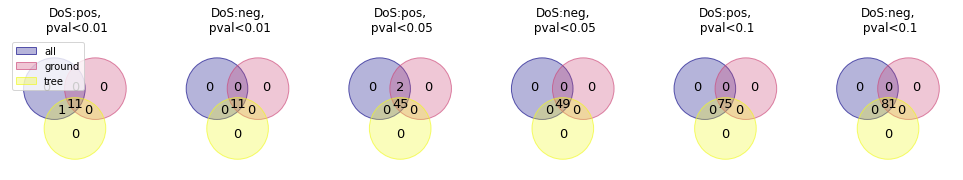

In [44]:
## Calculate overlap between dbs
# d1 = D['vidMac']
# d2 = D['vidCha']
d1 = D['indInd']
d2 = D['indInd_ground']
d3 = D['indInd_tree']
# db_sets = [ 'vidMac_str_pos', 'vidMac_str_neg', 'vidMac_pos', 'vidMac_neg',
#             'vidCha_str_pos', 'vidCha_str_neg', 'vidCha_pos', 'vidCha_neg']


fig, axes = plt.subplots(1, 6, figsize=(17, 12))


x = [('pos', .01), ('neg', .01), ('pos', .05), ('neg', .05), ('pos', .1), ('neg', .1)]
# x = [('pos', .01), ('neg', .01), ('pos', .05), ('neg', .05)]

for i in range(len(x)):
    db_set = x[i]
    dos = db_set[0]
    pval = db_set[1]
    all_db_sets = {}
    set_info1 = 'indInd_{}_{}'.format(dos, pval)
    set_info2 = 'indInd_ground_{}_{}'.format(dos, pval)
    set_info3 = 'indInd_tree_{}_{}'.format(dos, pval)
    all_db_sets[set_info1] = get_genes_dos_pval(d1, dos, pval)
    all_db_sets[set_info2] = get_genes_dos_pval(d2, dos, pval)
    all_db_sets[set_info3] = get_genes_dos_pval(d3, dos, pval)
#     print(all_db_sets[set_info1] & all_db_sets[set_info2]) 
    
    axi = axes[i]
    venn(all_db_sets, cmap='plasma', alpha=0.3, ax=axi)
    axi.set_title('DoS:{},\n pval<{}'.format(dos, pval))
    if i != 0:
        axi.legend(frameon=False)
    else:
        axi.legend(loc='upper left', labels=['all', 'ground', 'tree'])
        
# pdf_name = 'venns.DoS_pval.vidMac_vidCha.pdf'
pdf_name = 'venns.DoS_pval.indInd_all_ground_tree.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [21]:
len(vector_files)
    

44

In [20]:
vector_path = 'split_by_chr_PCA_indInd/'
vector_files = [dir_path + vector_path + f for f in listdir(dir_path + vector_path) if f.endswith('labeled')]

fig, axes = plt.subplots(6, 8, figsize=(4*8, 4*6))

for i in range(6):
    for j in range(8):

    f = vector_files[i]
    pca_df = pd.read_csv(f, sep='\t')
    
    axi = axes[i]
    sns.scatterplot(ax=axi, data=pca_df, x='PC1', y='PC2', hue='population')
    title = f.replace(dir_path + vector_path, '').replace('.passed.indInd.pca.eigenvec.labeled', '')
    axi.set_title('{}'.format(title))
    fig.tight_layout()  
    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

    if i != 0:
        axi.legend(frameon=False)
    i += 1


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: sharex argument to subplots() was an integer.  Did you intend to use subplot() (without 's')?
  after removing the cwd from sys.path.


ValueError: 1 is not a valid value for sharex; supported values are 'all', 'row', 'col', 'none'

<Figure size 12672x288 with 0 Axes>

'CM051111'

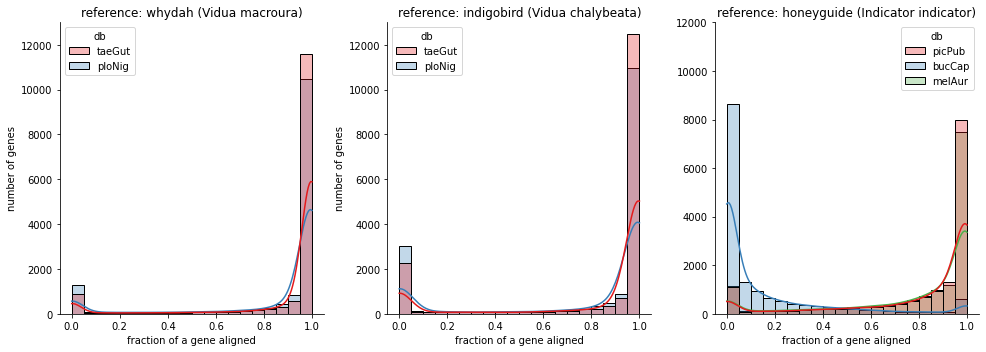

In [5]:
## Alignmnets from minimap2: what fraction of CDS do they cover?
file_name = 'Alignment_minimap_cov/bedcov_from_minimap2.tsv'
file_data = glob(dir_path + file_name)[0]
bedcov_df = pd.read_csv(file_data, sep='\t')

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.histplot(ax=axes[0], data=bedcov_df[bedcov_df['ref'] == 'vidMac'], x='fraction', hue='db',
             bins=20, kde=True, alpha=0.3, palette='Set1')
sns.histplot(ax=axes[1], data=bedcov_df[bedcov_df['ref'] == 'vidCha'], x='fraction', hue='db',
             bins=20, kde=True, alpha=0.3, palette='Set1')
sns.histplot(ax=axes[2], data=bedcov_df[bedcov_df['ref'] == 'indInd'], x='fraction', hue='db',
             bins=20, kde=True, alpha=0.3, palette='Set1')
# sns.histplot(ax=axes[2], data=bedcov_df[(bedcov_df['ref'] == 'indInd') & (bedcov_df['db'] != 'melAur')],
#              x='fraction', hue='db', bins=20, kde=True, alpha=0.3, palette='Set1')


axes[0].set_title('reference: whydah (Vidua macroura)')
axes[0].set(xlabel='fraction of a gene aligned', ylabel='number of genes')
axes[0].set(ylim=(0, 13000))
# axes[0].legend(title='', loc='upper left', labels=['zebra ficnh', 'weaver'])

axes[1].set_title('reference: indigobird (Vidua chalybeata)')
axes[1].set(xlabel='fraction of a gene aligned', ylabel='number of genes')
axes[1].set(ylim=(0, 13000))
# axes[1].legend(title='', loc='upper left', labels=['zebra ficnh', 'weaver'])

axes[2].set_title('reference: honeyguide (Indicator indicator)')
axes[2].set(xlabel='fraction of a gene aligned', ylabel='')
axes[2].set(ylim=(0, 12000))
# axes[2].legend(title='', loc='upper left', labels=['downy woodpecker', 'puffbird', 'golden-fronted woodpecker'])
# axes[2].legend(title='', loc='upper left', labels=['downy woodpecker', 'golden-fronted woodpecker'])
# axes[2].legend(title='', loc='upper left', labels=['downy woodpecker', 'puffbird'])


fig.tight_layout()  
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

# pdf_name = 'bedcov.fraction_of_genes_aligned.with_minimap2.no_woodpecker.pdf'

# fig.savefig(pdf_name, bbox_inches='tight')